### LeNet

Here is the LeNet model tailored for MNIST dataset (28x28x1).
The original LeNet had 32x32x1 as input dim.



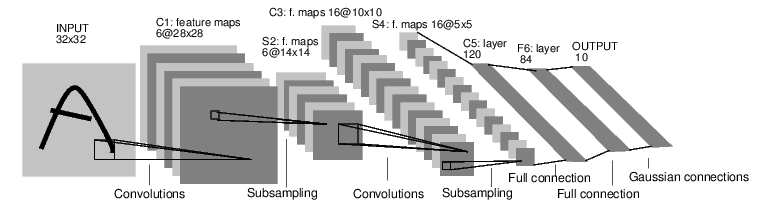

In [1]:
import torch
import numpy as np
import torch.autograd as ag
import torch.nn as nn
import torch.optim as optim

In [2]:
def flatten(x):
    # First dimension is the batch size
    size = x.size()[1:]
    dim = 1
    for s in size:
        dim *= s
    return dim

### Create the LetNet model

In [3]:
class LeNet(nn.Module):
    
    """
        Input is 28x28x1 sized images (MNIST)         28x28x1
        conv1 6 filters of 5x5, 0 padding, 1 stride   24x24x6
        relu                                          24x24x6
        pool1 2x2, 2 strides                          12x12x6
        conv2 16 filters of 5x5, 0 padding, 1 stride   8x8x16
        relu                                           8x8x16
        pool2 2x2, 2 strides                           4x4x16
        fully connected 120 nodes                         120
        fully connected 84 nodes                           84
        fully connected 10 nodes                           10 
        MSE loss function
    """
    
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1   = nn.Linear(4*4*16, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        
        x = x.view(-1, flatten(x))
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        
        return x


### Let's check the architecture

In [4]:
net = LeNet()
print(net)

LeNet (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (256 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


### Let's investigate the parameters

In [5]:
params = list(net.parameters())
print('\nLength of the parameter list is', len(params))
print('\nParameters for the 1st conv layer is\n', params[0])


Length of the parameter list is 10

Parameters for the 1st conv layer is
 Parameter containing:
(0 ,0 ,.,.) = 
 -0.1101 -0.1576 -0.1445  0.1429  0.1291
  0.1099  0.1741  0.1192 -0.1676  0.0967
 -0.0979 -0.0219  0.0449  0.1861 -0.1898
  0.0945  0.0233  0.1191  0.0668  0.0469
  0.0921  0.0431 -0.0441  0.0033 -0.1922

(1 ,0 ,.,.) = 
  0.0862  0.0257  0.1356  0.1363  0.1589
 -0.1375 -0.0498  0.1069 -0.1909  0.0547
 -0.1923  0.1315  0.1985  0.1675 -0.0481
  0.1436 -0.0338 -0.1170 -0.1080 -0.1949
 -0.0269  0.0247 -0.0654  0.1085 -0.0404

(2 ,0 ,.,.) = 
  0.0889 -0.1719  0.1071 -0.1420 -0.1646
 -0.0456  0.1253 -0.1838  0.0825  0.0072
  0.0142  0.1583  0.0161 -0.1394  0.1415
  0.1533  0.0830 -0.0552  0.0860  0.1602
  0.1655  0.1914 -0.1647  0.1946  0.1525

(3 ,0 ,.,.) = 
  0.0756 -0.0281  0.0870  0.0202  0.0505
  0.0909  0.0350 -0.0757 -0.1729  0.1712
  0.1141  0.0856 -0.1287  0.1579  0.0205
 -0.1382 -0.0530  0.1691 -0.1004  0.1599
 -0.0132  0.0266  0.0644 -0.1779 -0.1084

(4 ,0 ,.,.) = 
 -0.

### Let's inject some dummy data and investigate the output

In [6]:
dummy_input = ag.Variable(torch.rand(1, 1, 28, 28))
out = net(dummy_input)
print(out.data.numpy()) # we should get 10 numbers

[[ 0.04219276  0.09067416 -0.0250597  -0.04908771  0.10755441  0.12973978
   0.00575662  0.09346917 -0.0709964  -0.03147947]]


### Let's do a backward pass with dummy data

In [7]:
net.zero_grad()
inp = ag.Variable(torch.randn(1, 10))
out.backward(inp)
net.conv1.bias.grad

Variable containing:
1.00000e-02 *
  5.0826
 -1.2522
 -9.8442
  4.1426
 -1.5731
 -3.8071
[torch.FloatTensor of size 6]

### Let's add a loss function

In [8]:
dummy_input = ag.Variable(torch.rand(1, 1, 28, 28)) # input
out = net(dummy_input)
target = ag.Variable(torch.arange(1, 11)) # dummy target
criteria = nn.MSELoss()
loss = criteria(out, target)
print(loss)

Variable containing:
 38.2760
[torch.FloatTensor of size 1]



Check the gradient function chain

In [9]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

### Backpropagation

In [10]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
1.00000e-02 *
 -1.8604
  1.1379
 -0.5392
 -4.2463
  5.7314
  2.4256
[torch.FloatTensor of size 6]



### Weights update

In [11]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

OR

In [14]:
net1 = LeNet()
optimizer = optim.SGD(net1.parameters(), lr=0.01)
optimizer.zero_grad()
dummy_input = ag.Variable(torch.rand(1, 1, 28, 28)) # input
output = net1(dummy_input)
target = ag.Variable(torch.arange(1, 11)) # dummy target
criteria = nn.MSELoss()
loss = criteria(output, target)
loss.backward(retain_graph=True)
optimizer.step() # Do the parameter update

In [13]:
loss

Variable containing:
 38.2336
[torch.FloatTensor of size 1]